import packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from osgeo import gdal_array
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from torch import Tensor, einsum
from torch import nn
from torch.nn import functional as F
from scipy.ndimage import distance_transform_edt as distance
from scipy.spatial.distance import directed_hausdorff
from typing import Any, Callable, Iterable, List, Set, Tuple, TypeVar, Union
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F


In [2]:
!pip install segmentation-models-pytorch==0.1.0
!pip install keras-unet
!pip install pytorch-lighting
 

     |████████████████████████████████| 42 kB 123 kB/s 
     |████████████████████████████████| 58 kB 1.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=3ef6d76d9c417d9391b1fb6c98c13bb969bb04ace00478a381e501893e8ee0e7
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=44bf52889b6458d2a51016d4f7de831f95d6b65f4e884a7cc81fabc24a660844
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement 

In [3]:
import segmentation_models_pytorch as smp
from keras_unet.utils import plot_imgs

import pytorch_lightning as pl

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
tr_tiles=4
size = 128
bs = 16 #batchsize
classes = [7]
num_class = len(classes)
EPOCH = 300
reduce = 8

Used to crop the imput images

In [5]:
def slice (arr, size, inputsize,stride):
    result = []
    if stride is None:
        stride = size
    for i in range(0, (inputsize-size)+1, stride):
        for j in range(0, (inputsize-size)+1, stride):
        
            if arr.ndim == 3:
                s = arr[:,i:(i+size),j:(j+size), ]
            else:
                s = arr[i:(i+size),j:(j+size), ]
            result.append(s)
            #print(i,"",j)
    result = np.array(result)
    return result

def batchslice (arr, size, inputsize, stride, num_img):
    result = []
    for i in range(0, num_img):
        s= slice(arr[i,], size, inputsize, stride )
        result.append(s )
    result = np.array(result)
    result = result.reshape(result.shape[0]*result.shape[1], result.shape[2], result.shape[3], -1)
    return result

def class2dim (mask, CLASSES):
    
        masks = [(mask == v) for v in CLASSES ]
        mask = np.stack(masks, axis=-1).astype('float')    
        return mask

load the different tiles into 1 variable

In [6]:
#stack all files into 1 variable
def load_raster(path,data,tile1,tile2,reduce):
   tiles_in=[tile1,tile2]
   files = []
   for tile in tiles_in:
       for file in glob.glob(path+data+'*{}.tif'.format(tile)):
           file1 = gdal_array.LoadFile(file)
           #only use 50% of the points to reduce memory
           if np.ndim(file1)==3:
               file1=file1[:,::reduce,::reduce]
           else:
               file1=file1[::reduce,::reduce]
           files.append(file1)
   stacked = np.array(files)
   return stacked

def load_data(path,data1,data2,tile1,tile2, reduce):
    part1 = load_raster(path,data1,tile1,tile2, reduce )
    part2 = load_raster(path,data2,tile1,tile2,reduce )
    
    if np.ndim(part1)< np.ndim(part2):#check if dimmensions are equal
       part1 = np.expand_dims(part1,axis=1)
    elif np.ndim(part1)> np.ndim(part2):
       part2 = np.expand_dims(part2,axis=1)
    print(part1.shape,part2.shape)
    total = np.concatenate((part1,part2),axis=1)
    return total
def load_raster2(path,data,tile1,tile2,tile3,tile4,reduce):
   tiles_in=[tile1,tile2,tile3,tile4]
   files = []
   for tile in tiles_in:
       print(tile)
       for file in glob.glob(path+data+'*{}.tif'.format(tile)):
           file1 = gdal_array.LoadFile(file)
           #only use 50% of the points to reduce memory
           if np.ndim(file1)==3:
               file1=file1[:,::reduce,::reduce]
           else:
               file1=file1[::reduce,::reduce]
           files.append(file1)
           print(file1.shape)
   stacked = np.array(files)
   return stacked

def load_data2(path,data1,data2,tile1,tile2,tile3,tile4, reduce):
    part1 = load_raster2(path,data1,tile1,tile2,tile3,tile4,reduce )
    part2 = load_raster2(path,data2,tile1,tile2,tile3,tile4,reduce )
    
    if np.ndim(part1)< np.ndim(part2):#check if dimmensions are equal
       part1 = np.expand_dims(part1,axis=1)
    elif np.ndim(part1)> np.ndim(part2):
       part2 = np.expand_dims(part2,axis=1)
    print(part1.shape,part2.shape)
    total = np.concatenate((part1,part2),axis=1)
    return total
def load_raster3(path,data,tile1,tile2,tile3,tile4,tile5,tile6,tile7,tile8,reduce):
   tiles_in=[tile1,tile2,tile3,tile4,tile5,tile6,tile7,tile8]
   files = []
   for tile in tiles_in:
       print(tile)
       for file in glob.glob(path+data+'*{}.tif'.format(tile)):
           file1 = gdal_array.LoadFile(file)
           #only use 50% of the points to reduce memory
           if np.ndim(file1)==3:
               file1=file1[:,::reduce,::reduce]
           else:
               file1=file1[::reduce,::reduce]
           files.append(file1)
           print(file1.shape)
   stacked = np.array(files)
   return stacked

def load_data3(path,data1,data2,tile1,tile2,tile3,tile4,tile5,tile6,tile7,tile8 ,reduce):
    part1 = load_raster3(path,data1,tile1,tile2,tile3,tile4,tile5,tile6,tile7,tile8,reduce )
    part2 = load_raster3(path,data2,tile1,tile2,tile3,tile4,tile5,tile6,tile7,tile8,reduce )
    
    if np.ndim(part1)< np.ndim(part2):#check if dimmensions are equal
       part1 = np.expand_dims(part1,axis=1)
    elif np.ndim(part1)> np.ndim(part2):
       part2 = np.expand_dims(part2,axis=1)
    print(part1.shape,part2.shape)
    total = np.concatenate((part1,part2),axis=1)
    return total

In [7]:
if tr_tiles == 2:
    x_train0= load_data("../input/guided-research/Training/","DEM","Wadden","12_7","13_8",reduce)
    x_val0 = load_data("../input/guided-research/Training/","DEM","Wadden","12_8","14_7",reduce)
    y_train0= load_raster("../input/guided-research/Training/","class","12_7","13_8", reduce )
    y_val0=load_raster("../input/guided-research/Training/","class","12_8","14_7",reduce)
if tr_tiles == 4:
    x_train0= load_data2("../input/guided-research/Training/","DEM","Wadden","12_7","12_8","13_8","14_7",reduce)
    x_val0 = load_data("../input/guided-research/Validation/","DEM","Wadden","15_7","15_8",reduce)
    y_train0= load_raster2("../input/guided-research/Training/","class","12_7","12_8","13_8","14_7", reduce )
    y_val0=load_raster("../input/guided-research/Validation/","class","15_7","15_8",reduce)
if tr_tiles == 8:
    x_train0= load_data3("../input/guided-research/Training/","DEM","Wadden","12_7","12_8","13_6","13_7","13_8","13_9","14_7","15_7",reduce) 
    x_val0 = load_data("../input/guided-research/Validation/","DEM","Wadden","15_7","15_8",reduce) 
    y_train0= load_raster3("../input/guided-research/Training/","class","12_7","12_8","13_6","13_7","13_8","13_9","14_7","15_7",reduce )
    y_val0=load_raster("../input/guided-research/Validation/","class","15_7","15_8",reduce )  

12_7
(2000, 2000)
12_8
(2000, 2000)
13_8
(2000, 2000)
14_7
(2000, 2000)
12_7
(3, 2000, 2000)
12_8
(3, 2000, 2000)
13_8
(3, 2000, 2000)
14_7
(3, 2000, 2000)
(4, 1, 2000, 2000) (4, 3, 2000, 2000)
(2, 1, 2000, 2000) (2, 3, 2000, 2000)
12_7
(2000, 2000)
12_8
(2000, 2000)
13_8
(2000, 2000)
14_7
(2000, 2000)


In [8]:
print(x_train0.shape,x_val0.shape,y_train0.shape,y_val0.shape)

(4, 4, 2000, 2000) (2, 4, 2000, 2000) (4, 2000, 2000) (2, 2000, 2000)


In [9]:
def ndvi(input1):
    im =np.zeros(shape=(0,2000,2000))
    for i in range(input1.shape[0]):
        nir = input1[i,1,:,:]
        vis = input1[i,2,:,:]
        ndvi = (nir-vis)/(nir+vis)
        ndvi=np.expand_dims(ndvi,axis=0)
        im = np.concatenate([im,ndvi],axis=0)
    im = np.expand_dims(im,axis=1)
    outp = np.concatenate([input1,im],axis=1)
    return outp

In [10]:
x_train0 = ndvi(x_train0)
x_val0 = ndvi(x_val0)
print(x_train0.shape,x_val0.shape,y_train0.shape,y_val0.shape)

(4, 5, 2000, 2000) (2, 5, 2000, 2000) (4, 2000, 2000) (2, 2000, 2000)


In [11]:
print(np.unique(y_val0),np.unique(y_train0))

[1 5 6 7] [ 1  2  4  5  6  7  8  9 10 15]


Make class maps binary, 0 for other class 1 for 5

In [12]:
y_train0 = (y_train0==7).astype(int)
y_val0 = (y_val0==7).astype(int)
print(np.unique(y_val0),np.unique(y_train0))

[0 1] [0 1]


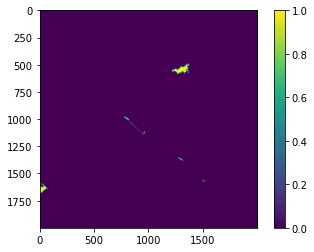

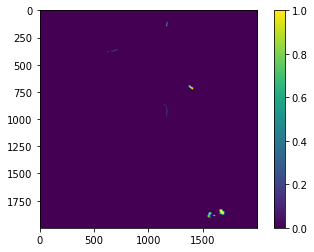

In [13]:
for i in range (2):
    plt.imshow(y_val0[i,])
    plt.colorbar()
    plt.show()

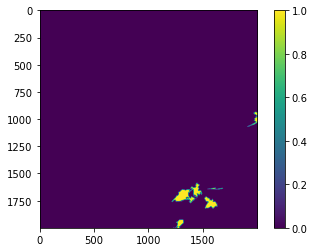

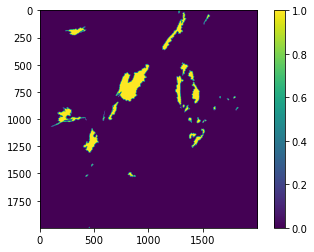

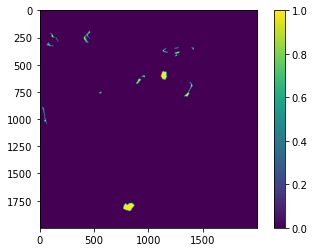

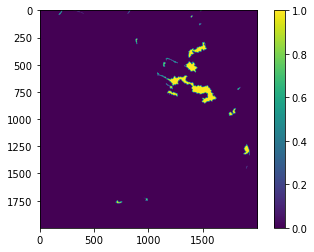

In [14]:
for i in range (4):
    plt.imshow(y_train0[i,])
    plt.colorbar()
    plt.show()

In [15]:
def process(x_train, x_val, y_train, y_val,  size, bslice=True, cl2dim=True, Inf2zero=True):
    if bslice :
        x_train  = batchslice(x_train, size,x_train[0].shape[1],size, x_train.shape[0])
        x_val = batchslice(x_val,size, x_val[0].shape[1], size, x_val.shape[0])
        y_train = batchslice(y_train,size,y_train[0].shape[1],size,y_train.shape[0]).squeeze()
        y_val = batchslice(y_val,size,y_val[0].shape[1],size,y_val.shape[0]).squeeze()
        print(f"batch slice to {size}")
       
    if  cl2dim :    
        y_train = class2dim(y_train, classes)
        y_val = class2dim(y_val, classes)

        y_train=  np.moveaxis(y_train, -1, 1)
        y_val = np.moveaxis(y_val, -1, 1)
        print("classes are converted to channels")
        
    if Inf2zero : 
        x_train[x_train > 1e308] = 0 
        #np.nan
        x_val [x_val > 1e308] =0 
        y_train[y_train >1e308] = 0
        y_val[y_val> 1e308] = 0
        print("inf are converted to 0")
    return(x_train, x_val, y_train, y_val)

def myloader(trainX, trainY, valX,valY):

    #train = TensorDataset(torch.Tensor(x_train[:,1:4,:,:]), torch.Tensor(y_train )) # create your datset
    train = TensorDataset(torch.Tensor(x_train[:,:,:,:]), torch.Tensor(y_train )) # create your datset
    train  = DataLoader(train, batch_size=bs) # create your dataloader
    
    #vali= TensorDataset(torch.Tensor(x_val[:,1:4,:,:]),torch.Tensor(y_val   )) # create your datset
    vali= TensorDataset(torch.Tensor(x_val[:,:,:,:]),torch.Tensor(y_val   )) # create your datset
    
    vali = DataLoader(vali, batch_size=bs) # create your dataloader
    return train , vali 

In [16]:
x_train, x_val, y_train, y_val = process(x_train0, x_val0, y_train0, y_val0, size =size, bslice=False, cl2dim=True, Inf2zero=True)

classes are converted to channels
inf are converted to 0


In [17]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(4, 5, 2000, 2000) (2, 5, 2000, 2000) (4, 1, 2000, 2000) (2, 1, 2000, 2000)


In [18]:
x_train, x_val, y_train, y_val = process(x_train0, x_val0, y_train0, y_val0, size =size, bslice=True, cl2dim=True, Inf2zero=True)

batch slice to 128
classes are converted to channels
inf are converted to 0


In [19]:
train_loader, valid_loader = myloader(x_train, y_train, x_val, y_val)

In [20]:
GAMMA = 2
ALPHA = 0.8 # emphasize FP
BETA = 0.2 # more emphasize on FN

# combo loss
cl_ALPHA = 0.5 # < 0.5 penalises FP more, > 0.5 penalises FN more
cl_BETA = 0.5
CE_RATIO = 0.5 #weighted contribution of modified CE loss compared to Dice loss
e=1e-07

In [21]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE


     
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, **kwargs):
        super(IoULoss, self).__init__(**kwargs)

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        #print(inputs.shape)
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        #inputs = (inputs>0.5).float()
        inputs = torch.where(inputs < 0.5,torch.tensor(0.).cuda(), inputs)
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()  
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth) 
                
        return 1 - IoU
    
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky
 

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

class myLoss(torch.nn.Module):

    def __init__(self, pos_weight=1):
      super().__init__()
      self.pos_weight = pos_weight

    def forward(self, input, target):
      epsilon = 10 ** -44
      input = input.sigmoid().clamp(epsilon, 1 - epsilon)

      my_bce_loss = -1 * (self.pos_weight * target * torch.log(input)
                          + (1 - target) * torch.log(1 - input))
      add_loss = (target - 0.5) ** 2 * 4
      mean_loss = (my_bce_loss * add_loss).mean()
      return mean_loss
    
 

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [22]:
class ComboLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ComboLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=cl_ALPHA, beta=cl_BETA):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        intersection = (inputs * targets).sum()    
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        inputs = torch.clamp(inputs, e, 1.0 - e)       
        out = - (cl_ALPHA * ((targets * torch.log(inputs)) + ((1 - cl_ALPHA) * (1.0 - targets) * torch.log(1.0 - inputs))))
        weighted_ce = out.mean(-1)
        combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)
        
        return combo

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
class myCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ComboLoss, self).__init__()

    def forward(self, outputs, labels, bs):


        batch_size = outputs.size()[0]            # batch_size
        outputs = F.log_softmax(outputs, dim=1)   # compute the log of softmax values
        outputs = outputs[range(batch_size), labels] # pick the values corresponding to the labels
        return -torch.sum(outputs)/bs

In [25]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [26]:
class CNNmodel(pl.LightningModule):
    def __init__(self):
        super(CNNmodel,self).__init__()
        self.batch_size=bs
        self.learning_rate = 2e-4
        self.net = smp.Unet(classes=num_class, in_channels=5, activation = 'sigmoid')
        self.label_type = torch.float32 if num_class  == 1 else torch.long
        self.accuracy = pl.metrics.Accuracy()
    def forward(self,x):
        return self.net(x)
    
    def training_step(self,train_batch,batch_nb):
        x,y = train_batch
        y = y.float()
        y_hat = self.net(x)
        #loss1= IoULoss()
        loss1=DiceBCELoss()
        loss = loss1(y_hat, y)
        result = pl.TrainResult(minimize=loss)
        result.log('train_acc_step', loss)
        return result
    
    def validation_step(self,val_batch,batch_nb):
        x,y = val_batch
        y = y.float()
        y_hat = self.net(x)
        #loss1 = IoULoss()
        loss1=DiceBCELoss()
        val_loss = loss1(y_hat, y)
        
        
        result = pl.EvalResult(checkpoint_on=val_loss)
        result.log('val_loss', val_loss, prog_bar=True, on_step=False, on_epoch=True)
        return result
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 40], gamma=0.3)
        return [optimizer],[scheduler]
    
    def train_dataloader(self):
        return train_loader
    
    def valid_dataloader(self):
        return valid_loader

In [27]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [28]:
pl.__version__

'0.9.0'

In [29]:
from pytorch_lightning import loggers as pl_loggers
tb_logger = pl_loggers.TensorBoardLogger('logs/')

In [30]:
model = CNNmodel()
#logdir_lightn = "segmentation_notebook_light"
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    filepath='sample-{epoch:02d}',
    prefix='')
trainer = pl.Trainer(logger=tb_logger,gpus=1,max_epochs = EPOCH,checkpoint_callback=checkpoint_callback)
modelt = trainer.fit(model,train_loader,valid_loader)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name     | Type     | Params
--------------------------------------
0 | net      | Unet     | 24 M  
1 | accuracy | Accuracy | 0     


Saving latest checkpoint..


In [31]:
print(checkpoint_callback.best_model_path,checkpoint_callback.best_model_score)
from IPython.display import FileLink
FileLink(checkpoint_callback.best_model_path[16:])

/kaggle/working/sample-epoch=299.ckpt tensor(0.8760, device='cuda:0')


/kaggle/working/sample-epoch=299.ckpt

after download changes the name to s_(#traingin_tiles)_(size)